# Implementing $\pi_{\rm int} + \pi_{\rm OU}$ on the semi-circle
Simulation of agent following pheromone along a semi-circle connecting points A and B for a given distance/angle followed by exploration under OU policy. The agent lays pheromone on the way back if it succeeds in reaching Point B.
## TOC:
* [Setting up pheromone environment](#first-bullet)
* [Agent following Intrinsic policy](#second-bullet)
* [Shifting to OU-policy](#third-bullet)
* [Setting up reward dynamics](#fourth-bullet)
* [Laying pheromone after success](#fifth-bullet)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time
from typing import Tuple, Iterable
from functools import partial
from typing import NamedTuple, Any
import random as rm

In [2]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

 ## <a class="anchor" id="first-bullet">Single epoch of agent dynamics</a>

In [49]:
# Parameters in the model
class params():
    def __init__(self) -> None:
        super().__init__()
        # Environment parameters
        self.a = 2.5 #radius of semi-circle
       
        # Pheromone parameters
        self.nMsh = 100 #number of points in pheromone mesh
        self.kM = 1 #rate of pheromone decay
        self.kP = 0.1 #rate of pheromone generation
        
        # Agent dynamics parameters
        self.nSteps = 10 #number of steps of each run
        self.nEpchs = 100 #number of epochs
        self.b = 0.5 #agent size (radius)
        self.dt = 1e-3 #time-step size
        self.l = 0.1 #length travelled in 1 time-step
        self.vo = self.l/self.dt #effective speed of motion
        self.alpha = 0.1 #orientation relaxation rate (s^-1)
        self.diff = 1e-3 #noise diffusion coefficient
        self.rInit = jnp.array([self.a+0.1, 0.01]) #initial location of agent
        self.phInit = jnp.array([0., 1.]) #initial orientation of agent

In [50]:
# Pheromone meshgrid
p = params()
xphm, yphm = np.meshgrid(np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh), np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh))
# Pheromone initial condition
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.b))  & (r < (p.a+p.b)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.0
        
class phrmn():
    def __init__(self, cInit):
        super().__init__()
        # self.c = jnp.zeros((nMsh, nMsh))
        self.c = cInit

    # @jit
    # def stepFwd(self, dt, r, kM, ):

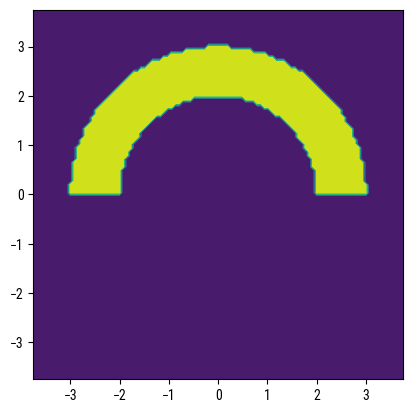

In [51]:
phm = phrmn(cInit)
fig, ax = plt.subplots(1,1)
ax.contourf(xphm, yphm, phm.c)
ax.set_aspect(1)
plt.show()

 ## <a class="anchor" id="second-bullet">Agent following Intrinsic policy</a>

In [61]:
# Single step dynamics of the agent
class agent():
    def __init__(self, r, phat, rng):
        super().__init__()
        self.r = r
        self.phat = phat
        self.rng = rng
    
    @jit
    def intPolicy(self, l, a):
        drng = random.split(self.rng)[0]
        
        phi = jnp.arctan2(self.r[1], self.r[0]) + random.uniform(drng, minval=-jnp.pi/50, maxval=jnp.pi/50)
        rCirc = jnp.array([a*jnp.cos(phi), a*jnp.sin(phi)])
        dr = rCirc - self.r
        dr = dr/jnp.linalg.norm(dr)
        that = jnp.array([-jnp.sin(phi), jnp.cos(phi)])
        phat = dr + that
        phat = phat/jnp.linalg.norm(phat)
        
        r = self.r + l*phat       
        return agent(r, phat, drng)
    @jit
    def ouPolicy(self, dt, l, diff, alpha):
        drng = random.split(self.rng)[0]
        phi = jnp.atan2(self.phat[1],self.phat[0])
        phat = jnp.array([-jnp.sin(phi), jnp.cos(phi)])
        self.r += l*phat
        phi = phi*(1-alpha*dt) + jnp.sqrt(2*diff*dt)*random.normal(drng)
        self.phat = jnp.array([-jnp.sin(phi), jnp.cos(phi)])
        return agent(self.r, self.phat, drng)
    
register_pytree_node(agent,
                     lambda x: ((x.r[0], x.r[1], x.phat[0], x.phat[1], x.rng), None),
                     lambda _, tup: agent(jnp.array([tup[0], tup[1]]), (tup[2], tup[3]), tup[4]))
                    #  ,
                    #  lambda _, tup: agent(jnp.array([tup[0], tup[1]]), (tup[2], tup[3]), tup[4]))

In [62]:
rng = random.PRNGKey(1)
p = params()
ag = agent(p.rInit, p.phInit, rng)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
phxFull = np.array(p.phInit[0])
phyFull = np.array(p.phInit[1])
for i in range(p.nSteps):
    ag = ag.intPolicy(p.l, p.a)
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    phxFull = np.vstack((phxFull, np.array(ag.phat[0])))
    phyFull = np.vstack((phyFull, np.array(ag.phat[1])))
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.07811784744262695 seconds ---


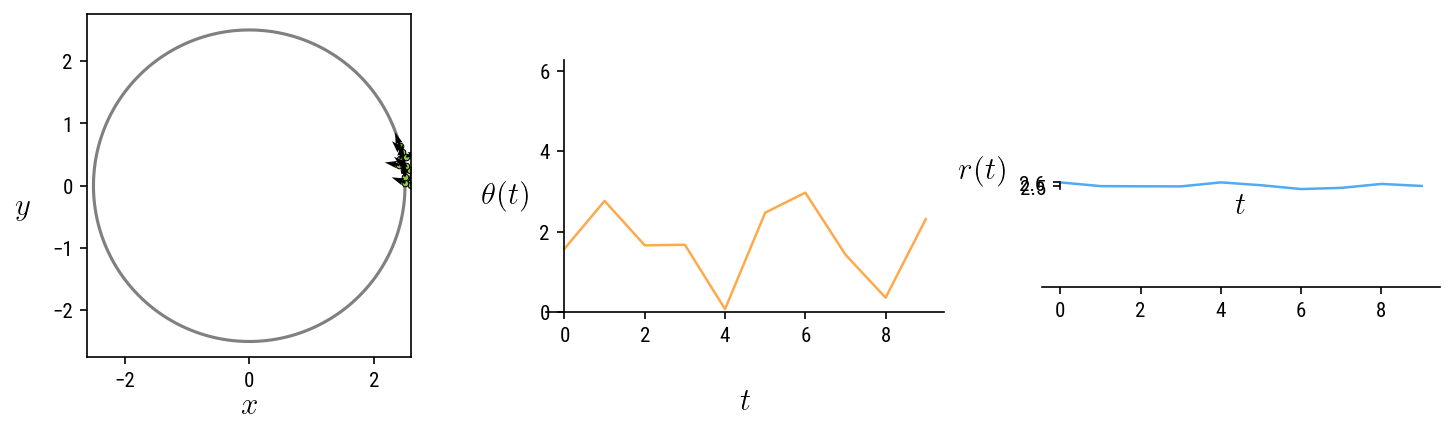

In [54]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Roboto Condensed")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

nRow = 1
nCol = 3
ax1 = plt.subplot(nRow, nCol, 1, aspect=1)
thetPlt = np.linspace(0., 2*np.pi, 200)
ax1.plot(p.a*np.cos(thetPlt), p.a*np.sin(thetPlt), c='gray', zorder=-1)
ax1.scatter(rxFull, ryFull,
            s=10,
            color=color,
            edgecolors='k',
            linewidth=0.5,
            zorder=-1)
ax1.quiver(rxFull, ryFull,
           phxFull, phyFull,
           scale_units='xy', scale=4.2)
ax1.set_xlim([-(p.a+p.l),(p.a+p.l)])
# ax1.set_ylim([0.,(p.a+p.l)])
ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

ax1.xaxis.set_label_coords(0.5,-0.1)
ax1.yaxis.set_label_coords(-0.2,0.4)


ax2 = plt.subplot(nRow, nCol, 2, aspect=1)
t = jnp.arange(p.nSteps)
thetFull = np.arctan2(phyFull[:-1], phxFull[:-1])
ax2.plot(t, np.mod(thetFull,2*np.pi),
        color=colors['orange'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)
ax2.set_ylim([0.,2*np.pi])

ax2.xaxis.set_label_coords(0.5,-0.3)
ax2.yaxis.set_label_coords(-0.1,0.4)

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_position(("data", 0))
ax2.spines["bottom"].set_position(("data", 0))

ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
t = jnp.arange(p.nSteps)
ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
        color=colors['blue'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax3.set_ylim([0.,2*np.pi])

ax3.xaxis.set_label_coords(0.5,-0.3)
ax3.yaxis.set_label_coords(-0.15,0.4)

ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_position(("data", 0))
ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

 ## <a class="anchor" id="first-bullet">Single epoch of agent dynamics</a>

--- 1.3583009243011475 seconds ---


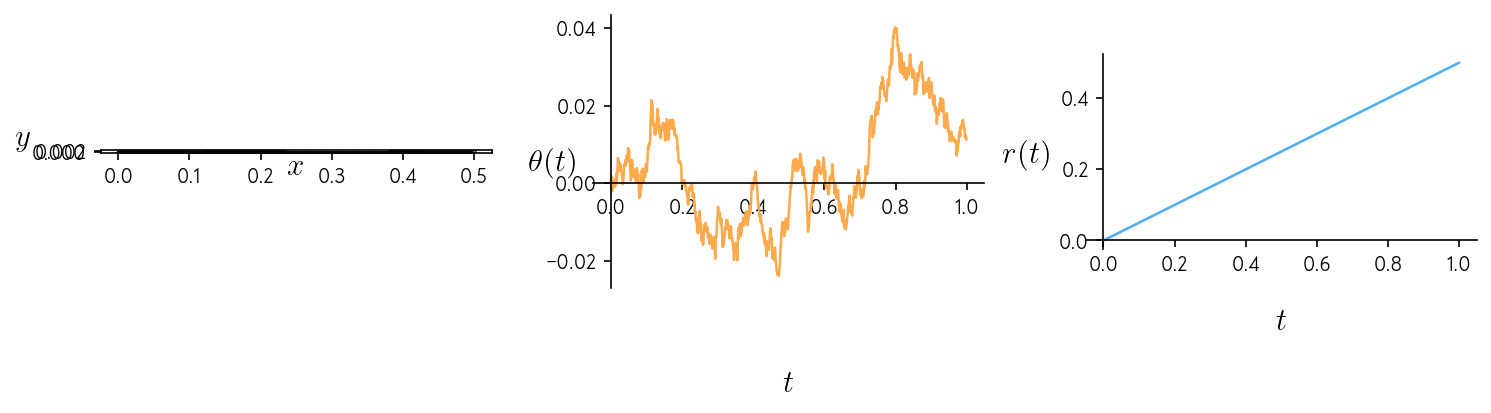

In [57]:
# Single epoch of agent dynamics for p.nSteps
rng = random.PRNGKey(rm.randint(0,10000))
p = params()
ag = agent(p.rInit, p.thInit, rng)
start_time = time.time()
rxFull = np.array(p.rInit[0])
ryFull = np.array(p.rInit[1])
thetFull = np.array(p.thInit)
for i in range(p.nSteps):
    ag = ag.stepFwd(p.dt, p.l, p.diff, p.alpha)
    rxFull = np.vstack((rxFull, np.array(ag.r[0])))
    ryFull = np.vstack((ryFull, np.array(ag.r[1])))
    thetFull = np.vstack((thetFull, np.array(ag.thet)))
print("--- %s seconds ---" % (time.time() - start_time))

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Noah")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

nRow = 1
nCol = 3
ax1 = plt.subplot(nRow, nCol, 1, aspect=1)

ax1.scatter(rxFull, ryFull,
            s=2,
            color=color,
            edgecolors='k',
            linewidth=0.5,
            zorder=-1)
# ax1.quiver(rxFull, ryFull,
#            jnp.cos(thetFull), jnp.sin(thetFull),
#            scale_units='xy', scale=0.8)
        #    , 'o', color=colors['orange'][4])
# ax1.set_xlim([0,2*p.nMax*p.dr])
# ax1.set_ylim([-p.nMax*p.dr,p.nMax*p.dr])
# ax1.set_xlim([0., 20.])
# ax1.set_ylim([-10., 10.])
ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

ax1.xaxis.set_label_coords(0.5,-0.1)
ax1.yaxis.set_label_coords(-0.2,0.4)


ax2 = plt.subplot(nRow, nCol, 2)
t = jnp.arange(p.nSteps)*p.dt
# ax2.plot(t, np.mod(thetFull[:-1],2*np.pi),
ax2.plot(t, thetFull[:-1],
        color=colors['orange'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax2.set_ylim([0.,2*np.pi])

ax2.xaxis.set_label_coords(0.5,-0.3)
ax2.yaxis.set_label_coords(-0.1,0.4)

ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_position(("data", 0))
ax2.spines["bottom"].set_position(("data", 0))

ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
        color=colors['blue'][4],
        clip_on=False,
        linewidth=linewidth,
        linestyle=linestyle,)
ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
# ax3.set_ylim([0.,2*np.pi])

ax3.xaxis.set_label_coords(0.5,-0.3)
ax3.yaxis.set_label_coords(-0.15,0.4)

ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["left"].set_position(("data", 0))
ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()

 ## <a class="anchor" id="second-bullet">Several epochs of dynamics</a>

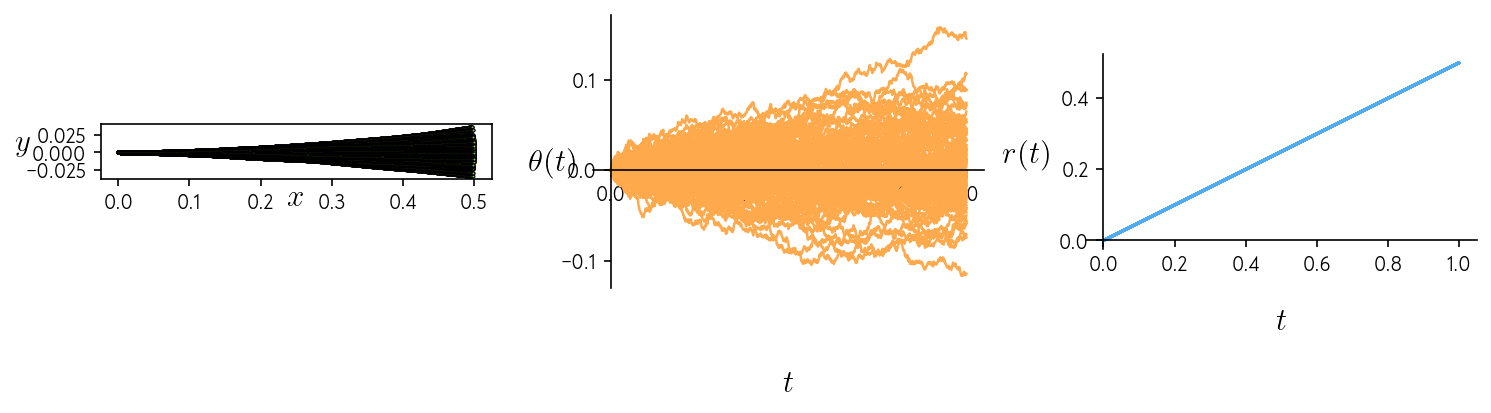

In [58]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Noah")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = '#8dc63f'

fig = plt.figure(figsize=(10, 3), dpi=150)

nrows, ncols = 2, 2
gspec = gridspec.GridSpec(
ncols=ncols, nrows=nrows, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1]
)

p = params()
for ind in np.arange(p.nEpchs):
    rng = random.PRNGKey(rm.randint(0,10000))
    ag = agent(p.rInit, p.thInit, rng)
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    thetFull = np.array(p.thInit)
    for i in range(p.nSteps):
        ag = ag.stepFwd(p.dt, p.l, p.diff, p.alpha)
        rxFull = np.vstack((rxFull, np.array(ag.r[0])))
        ryFull = np.vstack((ryFull, np.array(ag.r[1])))
        thetFull = np.vstack((thetFull, np.array(ag.thet)))


    nRow = 1
    nCol = 3
    ax1 = plt.subplot(nRow, nCol, 1, aspect=1)

    ax1.scatter(rxFull, ryFull,
                s=2,
                color=color,
                edgecolors='k',
                linewidth=0.5,
                zorder=-1)
    # ax1.quiver(rxFull, ryFull,
    #         jnp.cos(thetFull), jnp.sin(thetFull),
    #         scale_units='xy', scale=0.8)
            #    , 'o', color=colors['orange'][4])
    # ax1.set_xlim([0,2*p.nMax*p.dr])
    # ax1.set_ylim([-p.nMax*p.dr,p.nMax*p.dr])
    # ax1.set_xlim([0., 20.])
    # ax1.set_ylim([-10., 10.])
    ax1.set_xlabel(r'$x$',usetex=True, fontsize=label_size)
    ax1.set_ylabel(r'$y$',usetex=True,rotation=0, fontsize=label_size)

    ax1.xaxis.set_label_coords(0.5,-0.1)
    ax1.yaxis.set_label_coords(-0.2,0.4)


    ax2 = plt.subplot(nRow, nCol, 2)
    t = jnp.arange(p.nSteps)*p.dt
    ax2.plot(t, thetFull[:-1],
#     ax2.plot(t, np.mod(thetFull[:-1],2*np.pi),
            color=colors['orange'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax2.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax2.set_ylabel(r'$\theta(t)$',usetex=True,rotation=0, fontsize=label_size)
#     ax2.set_ylim([0.,2*np.pi])

    ax2.xaxis.set_label_coords(0.5,-0.3)
    ax2.yaxis.set_label_coords(-0.1,0.4)

    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_position(("data", 0))
    ax2.spines["bottom"].set_position(("data", 0))

    ax3 = plt.subplot(nRow, nCol, 3, aspect=1)
    ax3.plot(t, np.sqrt(rxFull[:-1]**2 + ryFull[:-1]**2),
            color=colors['blue'][4],
            clip_on=False,
            linewidth=linewidth,
            linestyle=linestyle,)
    ax3.set_xlabel(r'$t$',usetex=True, fontsize=label_size)
    ax3.set_ylabel(r'$r(t)$',usetex=True,rotation=0, fontsize=label_size)
    # ax3.set_ylim([0.,2*np.pi])

    ax3.xaxis.set_label_coords(0.5,-0.3)
    ax3.yaxis.set_label_coords(-0.15,0.4)

    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_position(("data", 0))
    ax3.spines["bottom"].set_position(("data", 0))


plt.tight_layout()
plt.show()